**Name:** LOW Zhi Hao

**EID:** zhlow2

# CS4487 - Tutorial 7: Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use linear dimensionality reduction on face images, and then train a classifier for face recognition.

First we need to initialize Python.  Run the below cell.

In [20]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)

## 1. Loading Data and Pre-processing
We first need to load the images.  Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [21]:
oli = datasets.fetch_olivetti_faces()
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


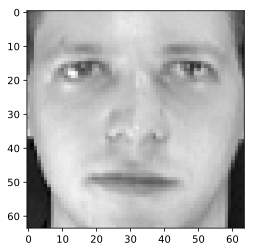

In [22]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

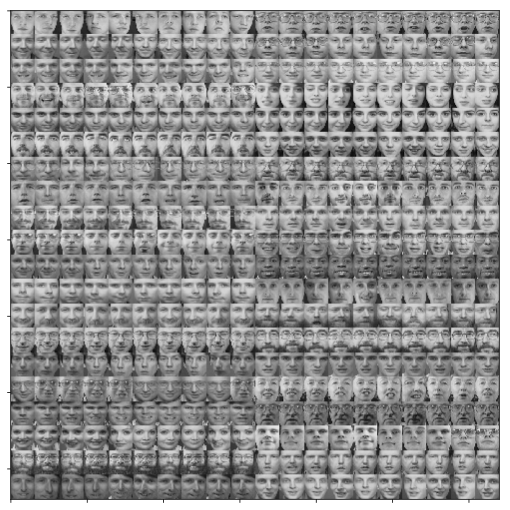

In [23]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [24]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


## 2. Principal Component Analysis - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [47]:
### INSERT YOUR CODE HERE
## HINT
# 1.decomposition.PCA(n_components=9)
pca = decomposition.PCA(n_components=9)
pca.fit(trainX)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [48]:
trainX.dtype

dtype('float32')

The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [53]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    elif cname == 'TruncatedSVD':
        KK = model.n_components
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = ceil(K/5.0)
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

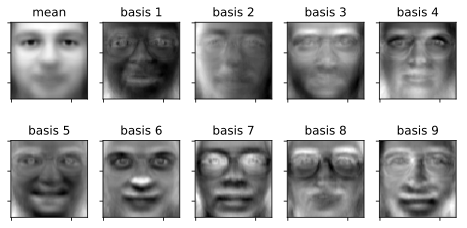

In [50]:
# run the function
plot_basis(pca, imgsize)

_What do the basis images look like? Do some basis images correspond to particular facial features?_
- mean is the average face
- basis 7, 8, and 9 are different glasses frames
- basis 3 is about eye brows
- basis 4 is about eyes.
- basis 6 gives the highlights of nose, like depth
- basis 1 gives the inverse image

### Face Recognition
Now train a logistic classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components. Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!



In [34]:
### INSERT YOUR CODE HERE
## HINT
# 1. linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
# 2. calculate accuracy: metrics.accuracy_score
lrcv = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)

trainXPCA = pca.transform(trainX)
testXPCA = pca.transform(testX)

lrcv.fit(trainXPCA, trainY)

trainPred = lrcv.predict(trainXPCA)
testPred = lrcv.predict(testXPCA)

print('Training Accuracy: ')
print(metrics.accuracy_score(trainPred, trainY))
print()
print('Testing Accuracy: ')
print(metrics.accuracy_score(testPred, testY))

Training Accuracy: 
0.840625
Testing Accuracy: 
0.7


### Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

In [43]:
ns=[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

params = {'C': logspace(-6,3,15)}
trainacc = []
testacc = []
for n in ns:
    ### INSERT YOUR CODE HERE
    ## HINT
    # 1. decomposition.PCA(n_components=n)
    print(f'============== {n} components ==============')
    temp_pca = decomposition.PCA(n_components=n)
    temp_pca.fit(trainX)
    temp_lrcv = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)

    temp_trainXPCA = temp_pca.transform(trainX)
    temp_testXPCA = temp_pca.transform(testX)

    temp_lrcv.fit(temp_trainXPCA, trainY)

    temp_trainPred = temp_lrcv.predict(temp_trainXPCA)
    temp_testPred = temp_lrcv.predict(temp_testXPCA)

    print('Training Accuracy: ')
    trainacc.append(metrics.accuracy_score(temp_trainPred, trainY))
    print(trainacc[len(trainacc)-1])
    print()
    print('Testing Accuracy: ')
    testacc.append(metrics.accuracy_score(temp_testPred, testY))
    print(testacc[len(testacc)-1])
    print('\n')
    
    # 2. linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    # 3. calculate accuracy: metrics.accuracy_score

============== 1 components ==============
Training Accuracy: 
0.071875

Testing Accuracy: 
0.0375


============== 5 components ==============
Training Accuracy: 
0.40625

Testing Accuracy: 
0.3625


============== 10 components ==============
Training Accuracy: 
0.9

Testing Accuracy: 
0.7


============== 15 components ==============
Training Accuracy: 
0.9875

Testing Accuracy: 
0.8125


============== 20 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.9


============== 25 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.925


============== 30 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.925


============== 35 components ==============
Training Accuracy: 
0.99375

Testing Accuracy: 
0.9125


============== 40 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.9125


============== 45 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.925


============== 50 compone

Text(0,0.5,'accuracy')

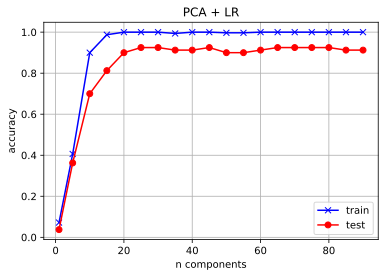

In [44]:
plt.plot(ns, trainacc, 'bx-', label='train')
plt.plot(ns, testacc, 'ro-', label='test')
plt.title("PCA + LR")
plt.legend(loc=0)
plt.grid(True); plt.xlabel('n components'); plt.ylabel('accuracy')

_What is the best number of components?  View the basis images to see what they look like_
- about 20 components is sufficient to get maximum accuracy

Plot the basis vectors of PCA with 20 components

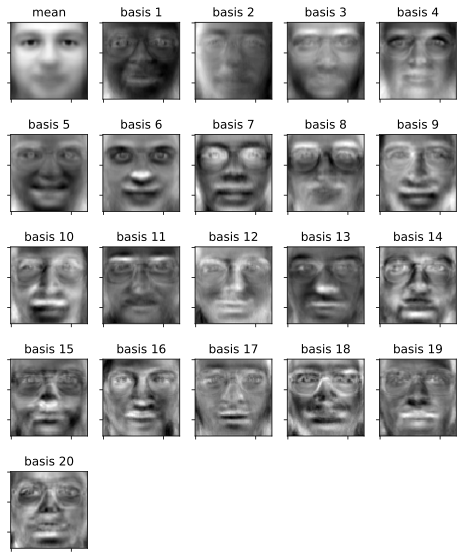

In [45]:
### INSERT YOUR CODE HERE
# HINT
# decomposition.PCA(n_components=20)
pca_20 = decomposition.PCA(n_components=20)
pca_20.fit(trainX)
plot_basis(pca_20, imgsize)

# 3. Linear Dimensionality Reduction - SVD

Now we will repeat the experiment using non-negative matrix factorization instead of PCA. Perform SVD with 9 components and visualize the basis images.

TruncatedSVD


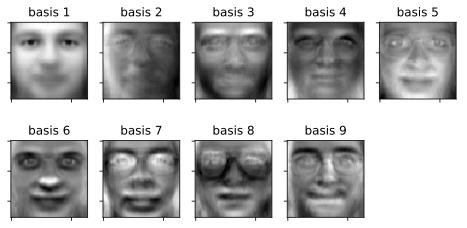

In [54]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.TruncatedSVD(n_components=9)
tsvd = decomposition.TruncatedSVD(n_components=9)
tsvd.fit(trainX)
print(tsvd.__class__.__name__)
plot_basis(tsvd, imgsize)

### Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

In [55]:
ns=[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

params = {'C': logspace(-6,3,15)}
trainacc = []
testacc = []
for n in ns:
    ### INSERT YOUR CODE HERE
    ## HINT
    # 1. decomposition.TruncatedSVD(n_components=n)
    # 2. linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    # 3. calculate accuracy: metrics.accuracy_score
    print(f'============== {n} components ==============')
    temp_tsvd = decomposition.TruncatedSVD(n_components=n)
    temp_tsvd.fit(trainX)
    temp_lrcv = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)

    temp_trainXsvd = temp_tsvd.transform(trainX)
    temp_testXsvd = temp_tsvd.transform(testX)

    temp_lrcv.fit(temp_trainXsvd, trainY)

    temp_trainPred = temp_lrcv.predict(temp_trainXsvd)
    temp_testPred = temp_lrcv.predict(temp_testXsvd)

    print('Training Accuracy: ')
    trainacc.append(metrics.accuracy_score(temp_trainPred, trainY))
    print(trainacc[len(trainacc)-1])
    print()
    print('Testing Accuracy: ')
    testacc.append(metrics.accuracy_score(temp_testPred, testY))
    print(testacc[len(testacc)-1])
    print('\n')

============== 1 components ==============
Training Accuracy: 
0.090625

Testing Accuracy: 
0.0375


============== 5 components ==============
Training Accuracy: 
0.415625

Testing Accuracy: 
0.35


============== 10 components ==============
Training Accuracy: 
0.9125

Testing Accuracy: 
0.7


============== 15 components ==============
Training Accuracy: 
0.9875

Testing Accuracy: 
0.85


============== 20 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.9125


============== 25 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.9125


============== 30 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.925


============== 35 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.925


============== 40 components ==============
Training Accuracy: 
1.0

Testing Accuracy: 
0.9375


============== 45 components ==============
Training Accuracy: 
0.996875

Testing Accuracy: 
0.9


============== 50 compo

Text(0,0.5,'accuracy')

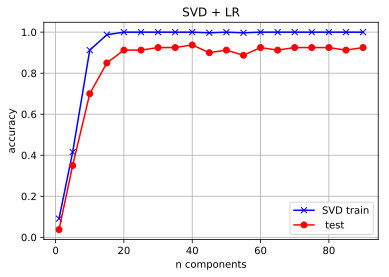

In [56]:
plt.plot(ns, trainacc, 'bx-', label='SVD train')
plt.plot(ns, testacc, 'ro-', label=' test')
plt.title("SVD + LR")
plt.legend(loc=0)
plt.grid(True); plt.xlabel('n components'); plt.ylabel('accuracy')

_Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is SVD or PCA better?_

- 20 components will have good results
- PCA is better (test accuracy > 90%), and more stable than SVD.

Plot the basis vectors of PCA with 35 components

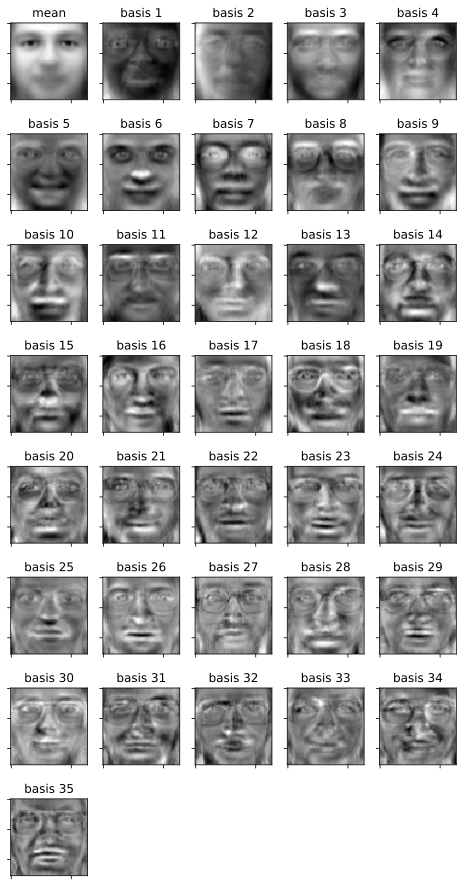

In [57]:
### INSERT YOUR CODE HERE
# HINT
pca_20 = decomposition.PCA(n_components=35)
pca_20.fit(trainX)
plot_basis(pca_20, imgsize)